In [188]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import decouple
import functools
config = decouple.AutoConfig(' ')
import itertools
import cv2

In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.0.1-arm64-arm-64bit
Tensor Flow Version: 2.11.0
Keras Version: 2.11.0

Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas 1.5.2
Scikit-Learn 1.2.0
GPU is available


# initial data exploration

In [146]:
class HelperFunc:
    def absoluteFilePaths(self, directory):
        for dirpath,dirnames,filenames in os.walk(directory):
            if len(dirnames) == 0:
                for f in filenames:
                    yield os.path.abspath(os.path.join(dirpath, f))
            else:
                # dir_tree = {}
                for d in dirnames:
                    # dir_tree[d] = self.absoluteFilePaths(os.path.join(dirpath, d))
                    yield from self.absoluteFilePaths(os.path.join(dirpath, d)) # same as from f in absoluteFilePaths(os.path.join(dirpath, d)): yield f
                # yield dir_tree

    def absoluteFilePaths2(self, directory):
        for dirpath,dirnames,filenames in os.walk(directory):
            # for f in filenames:
            #     yield os.path.abspath(os.path.join(dirpath, f))
            if len(dirnames) > 0:
                continue
            else:
                for f in filenames:
                    yield os.path.abspath(os.path.join(dirpath, f))

    def get_directory_structure(self, rootdir):
        """
        Creates a nested dictionary that represents the folder structure of rootdir
        """
        dir = {}
        rootdir = rootdir.rstrip(os.sep)
        start = rootdir.rfind(os.sep) + 1
        for path, dirs, files in os.walk(rootdir):
            folders = path[start:].split(os.sep)
            subdir = dict.fromkeys(files)
            parent = functools.reduce(dict.get, folders[:-1], dir)
            parent[folders[-1]] = subdir
        return dir

helpers = HelperFunc()
     
DATA_DIR = config('DATA_DIR')
FUMPE_PATH = DATA_DIR+'/FUMPE'

ground_truths = helpers.absoluteFilePaths(FUMPE_PATH+'/GroundTruth')
eg_mat = next(ground_truths)
print(eg_mat)

dir_struct = helpers.get_directory_structure(FUMPE_PATH+'/CT_scans')
dir_struct['CT_scans'].keys()

/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/GroundTruth/PAT024.mat


dict_keys(['.DS_Store', 'PAT001', 'PAT006', 'PAT030', 'PAT008', 'PAT009', 'PAT031', 'PAT007', 'PAT022', 'PAT025', 'PAT013', 'PAT014', 'PAT015', 'PAT012', 'PAT024', 'PAT023', 'PAT005', 'PAT002', 'PAT034', 'PAT033', 'PAT032', 'PAT035', 'PAT003', 'PAT004', 'PAT019', 'PAT026', 'PAT021', 'PAT028', 'PAT017', 'PAT010', 'PAT011', 'PAT029', 'PAT016', 'PAT020', 'PAT018', 'PAT027'])

In [119]:
import scipy.io
mat = scipy.io.loadmat(eg_mat)
truth_arr =  mat['Mask']
print(truth_arr.shape) # first 2 dimensions are the size of the image + labels indexed by (x, y), last dimension is the number of dicoms per patient -> varies by patient

# plt.imshow(truth_arr[:, :, 0])

(512, 512, 139)


In [125]:
dicom_files = list(helpers.absoluteFilePaths(FUMPE_PATH+'/CT_scans'))
# eg_dicom = next(dicom_files) # returns the dict
# print(eg_dicom)
# print(next(eg_dicom['PAT001']))
# eg2_dicom = next(dicom_files) # returns the first file in the first subdirectory, i guess each iteration traverses the tree in order of subdirectory->file->next subdirectory->next file
# print(eg2_dicom)
dicom_files

['/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0006.dcm',
 '/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0012.dcm',
 '/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0199.dcm',
 '/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0172.dcm',
 '/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0166.dcm',
 '/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0167.dcm',
 '/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0173.dcm',
 '/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0198.dcm',
 '/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0013.dcm',
 '/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0007.dcm',
 '/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0011.dcm',
 '/Users/anushmutyala/Documents/research/AI

In [88]:
for f in helpers.absoluteFilePaths2(FUMPE_PATH+'/CT_scans'):
    print(f)

/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0006.dcm
/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0012.dcm
/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0199.dcm
/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0172.dcm
/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0166.dcm
/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0167.dcm
/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0173.dcm
/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0198.dcm
/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0013.dcm
/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0007.dcm
/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0011.dcm
/Users/anushmutyala/Documents/research/AI/Datasets/FUMPE/CT_scans/PAT001/D0005.dcm
/Use

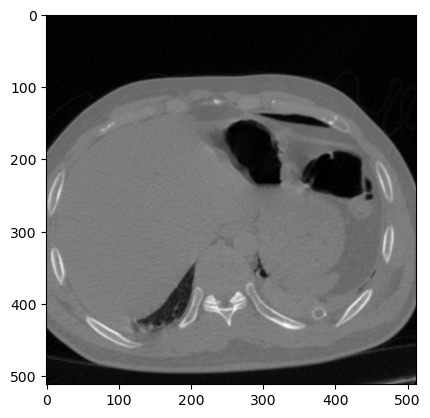

In [126]:
import pydicom

import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file

# The path to a pydicom test dataset
# path = get_testdata_file("CT_small.dcm")
ds = dcmread(dicom_files[0])
# `arr` is a numpy.ndarray
arr = ds.pixel_array

plt.imshow(arr, cmap="gray")
plt.show()

# data preprocessing

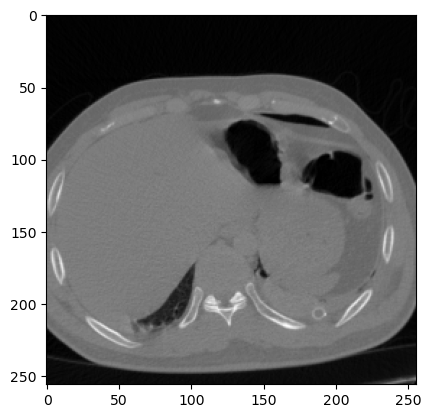

In [127]:
res = cv2.resize(arr, dsize=(256, 256), interpolation=cv2.INTER_CUBIC) # resize to 256x256

plt.imshow(res, cmap="gray")
plt.show()



In [220]:
class DataLoader:
    def __init__(self, data_dir, label_dir):
        self.data_dir = data_dir
        self.label_dir = label_dir
        # self.label_paths = helpers.absoluteFilePaths(self.label_dir)
        # self.data_paths = helpers.absoluteFilePaths(self.data_dir)
        self.label_tree = helpers.get_directory_structure(self.label_dir)
        self.data_tree = helpers.get_directory_structure(self.data_dir)
        self.label_arrs = self.__load_labels__()
        self.data_arrs = self.__load_data__()

    def __len__(self):
        return len(self.label_tree)

    def __getitem__(self):
        pass

    def __load_labels__(self):
        label_tree = self.label_tree
        # print(label_paths.keys())
        label_paths = [os.path.abspath(os.path.join(self.label_dir, path)) for path in label_tree[list(label_tree.keys())[0]]]
        label_paths.sort(key=lambda x: int(x.split('/')[-1].split('.')[0][-3:]))
        # for label_path in label_tree[list(label_tree.keys())[0]]:
        #     print(os.path.abspath(os.path.join(self.label_dir, label_path)))

        # label_arrs = []
        # for label_path in label_paths:
        #     mat = scipy.io.loadmat(label_path)
        #     truth_arr =  mat['Mask']
        #     label_arrs.append(truth_arr)
        # yield label_arrs
        
        for label_path in label_paths:
            # print(label_path)
            mat = scipy.io.loadmat(label_path)
            truth_arr =  cv2.resize(mat['Mask'], dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
            yield truth_arr

    def __load_data__(self):
        data_tree = self.data_tree
        patient_paths = [os.path.abspath(os.path.join(self.data_dir, path)) for path in data_tree[list(data_tree.keys())[0]]]
        # print(patient_paths)
        patient_data = []
        for patient_dir in list(data_tree[list(data_tree.keys())[0]].items())[1:]: # first file is always .DS_Store
            # print(patient_dir[1])
            file_paths = [os.path.abspath(os.path.join(self.data_dir, patient_dir[0], file)) for file in patient_dir[1]]
            file_paths.sort(key=lambda x: int(x.split('/')[-1].split('.')[0][-3:]))
            # print(file_paths)
            pat_data = []
            for file_path in file_paths: # in this loop add all preprocessing applied on images 
                ds = dcmread(file_path)
                arr = ds.pixel_array
                arr = cv2.resize(arr, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
                pat_data.append(arr)
            yield np.array(pat_data)

FUMPE_dataset = DataLoader(FUMPE_PATH+'/CT_scans', FUMPE_PATH+'/GroundTruth')
# print(FUMPE_dataset.data_paths)
# FUMPE_dataset.label_paths
print(next(FUMPE_dataset.label_arrs).shape)
print(next(FUMPE_dataset.data_arrs).shape)

(256, 256, 201)
(201, 256, 256)


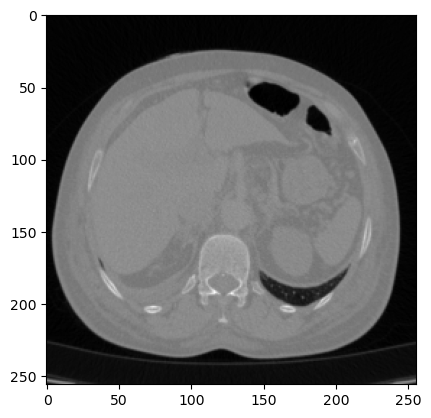

In [221]:
eg_arr = next(FUMPE_dataset.data_arrs)

plt.imshow(eg_arr[0, :, :], cmap="gray")